In [1]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import astropy.units as u
from astropy.coordinates import ICRS
import astropy.coordinates as apycoords
from astropy.coordinates import CylindricalRepresentation, CylindricalDifferential

# Error propegation for velocity components

In [2]:
vphi_data = 'v_dataset.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [3]:
pd.set_option('display.max_columns', None)

df_v.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,-14.428048,4.529900
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,42.346437,-2.860027
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,-51.045366,13.944756
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,62.829005,-53.068842
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,1.866465,13.969564


In [4]:
rpgeo_error = ((df_v['B_rpgeo_xa'] - df_v['rpgeo']) + (df_v['rpgeo'] - df_v['b_rpgeo_x'])) / 2

df_v['rpgeo_error'] = rpgeo_error

In [5]:
# Compute the correlation coefficient for pmra and pmdec
# Extract relevant columns from your DataFrame
pmra = df_v['pmra'].values
pmdec = df_v['pmdec'].values

# Calculate the covariance matrix for pmra and pmdec
cov_pmra_pmdec = np.cov(pmra, pmdec)[0, 1]
sigma_pmra = np.std(pmra)
sigma_pmdec = np.std(pmdec)

# Calculate the correlation coefficient
correlation_pmra_pmdec = cov_pmra_pmdec / (sigma_pmra * sigma_pmdec)

In [6]:
# Number of samples for uncertainty propagation
N_SAMPLES = 100

# Define the Sun's velocity with respect to the Galactic center
V_SUN = CartesianDifferential([11.1, 245., 7.25] * u.km / u.s)

# Define the Galactocentric frame with Sun's motion
GC_FRAME = Galactocentric(
    galcen_distance=8.1 * u.kpc, 
    z_sun=25 * u.pc, 
    galcen_v_sun=V_SUN
)


In [7]:
def generate_monte_carlo_samples(df_chunk, n_samples, correlation_pmra_pmdec):
    """
    Generate 100 perturbed samples for each star using its uncertainties.
    
    Args:
        - df_chunk: Subset of the dataframe containing stellar data.
        - n_samples: Number of samples per star (default: 100).
        - correlation_pmra_pmdec: Correlation coefficient between PMRA and PMDEC.
    
    Returns:
        - Tuple of sampled arrays (ra_samples, dec_samples, distance_samples, pmra_samples, pmdec_samples, vlos_samples)
    """
    num_stars = len(df_chunk)

    # Extract values and uncertainties
    ra, dec, distance = df_chunk['ra'].values, df_chunk['dec'].values, df_chunk['rpgeo'].values
    pmra, pmdec = df_chunk['pmra'].values, df_chunk['pmdec'].values
    vlos = df_chunk['radial_velocity'].values

    # Measurement uncertainties
    pmra_err, pmdec_err = df_chunk['pmra_error'].values, df_chunk['pmdec_error'].values
    dist_err = df_chunk['rpgeo_error'].values
    vlos_err = df_chunk['radial_velocity_error'].values
    parallax_err = df_chunk['parallax_error'].values

    # Preallocate arrays for the 100 Monte Carlo samples
    ra_samples = np.random.normal(ra[:, None], parallax_err[:, None], (num_stars, n_samples))
    dec_samples = np.random.normal(dec[:, None], parallax_err[:, None], (num_stars, n_samples))
    distance_samples = np.random.normal(distance[:, None], dist_err[:, None], (num_stars, n_samples))
    vlos_samples = np.random.normal(vlos[:, None], vlos_err[:, None], (num_stars, n_samples))

    # Generate correlated proper motion samples
    pmra_samples = np.zeros((num_stars, n_samples))
    pmdec_samples = np.zeros((num_stars, n_samples))

    for i in tqdm(range(num_stars), desc="Generating Monte Carlo Samples"):
        # Construct covariance matrix
        cov_pmra_pmdec = correlation_pmra_pmdec * pmra_err[i] * pmdec_err[i]
        cov_matrix = np.array([[pmra_err[i]**2, cov_pmra_pmdec], [cov_pmra_pmdec, pmdec_err[i]**2]])

        # Generate 100 samples for PMRA and PMDEC
        pm_samples = np.random.multivariate_normal([pmra[i], pmdec[i]], cov_matrix, n_samples)
        pmra_samples[i, :], pmdec_samples[i, :] = pm_samples[:, 0], pm_samples[:, 1]

    # Clip dec_samples to be within [-90, 90] degrees
    dec_samples = np.clip(dec_samples, -90, 90)

    # Ensure ra_samples are within [0, 360] degrees
    ra_samples = np.mod(ra_samples, 360)

    # Clip distance_samples to ensure all distances are >= 0
    distance_samples = np.clip(distance_samples, 1e-5, None)

    return ra_samples, dec_samples, distance_samples, pmra_samples, pmdec_samples, vlos_samples


In [8]:
def compute_velocity_components_with_uncertainty(ra, dec, distance, pmra, pmdec, vlos, gc_frame):
    """
    Compute cylindrical velocity components (v_R, v_phi, v_Z) for a given set of stellar parameters.

    Args:
        - ra (array): Right Ascension (degrees)
        - dec (array): Declination (degrees)
        - distance (array): Distance (pc)
        - pmra (array): Proper motion in RA (mas/yr)
        - pmdec (array): Proper motion in Dec (mas/yr)
        - vlos (array): Line-of-sight velocity (km/s)
        - gc_frame: Galactocentric reference frame

    Returns:
        - v_R (array): Radial velocity (km/s)
        - v_phi (array): Azimuthal velocity (km/s)
        - v_Z (array): Vertical velocity (km/s)
    """
    # Create a SkyCoord object for all sources at once
    coords = ICRS(
        ra=ra, dec=dec, distance=distance,
        pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vlos
    )

    # Transform to Galactocentric frame
    cg = coords.transform_to(gc_frame)
    cg.representation = 'cylindrical'

    # Convert to cylindrical representation and extract velocity components
    cg_cyl = cg.represent_as(CylindricalRepresentation)
    cg_cyl_vel = cg.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']

    # Compute velocities in km/s
    v_r_kms = cg_cyl_vel.d_rho.to(u.km / u.s).value
    v_phi_kms = -(cg_cyl_vel.d_phi.to(u.rad / u.s) * cg_cyl.rho.to(u.km)).value
    v_z_kms = cg_cyl_vel.d_z.to(u.km / u.s).value

    return v_r_kms, v_phi_kms, v_z_kms


In [9]:
def compute_velocity_components_for_samples(ra_samples, dec_samples, distance_samples, 
                                            pmra_samples, pmdec_samples, vlos_samples, gc_frame):
    """
    Compute velocity components (v_R, v_phi, v_Z) for each Monte Carlo sample.

    Args:
        - ra_samples, dec_samples, distance_samples: Arrays of shape (num_stars, 100)
        - pmra_samples, pmdec_samples, vlos_samples: Arrays of shape (num_stars, 100)
        - gc_frame: Galactocentric reference frame

    Returns:
        - v_R_samples, v_phi_samples, v_Z_samples: Arrays of shape (num_stars, 100)
    """
    num_stars, n_samples = ra_samples.shape

    v_R_samples = np.zeros((num_stars, n_samples))
    v_phi_samples = np.zeros((num_stars, n_samples))
    v_Z_samples = np.zeros((num_stars, n_samples))

    for i in tqdm(range(n_samples), desc="Computing Velocities for Monte Carlo Samples"):
        # Compute velocity for each realization
        v_R, v_phi, v_Z = compute_velocity_components_with_uncertainty(
            ra_samples[:, i] * u.deg, dec_samples[:, i] * u.deg, distance_samples[:, i] * u.pc,
            pmra_samples[:, i] * u.mas / u.yr, pmdec_samples[:, i] * u.mas / u.yr, vlos_samples[:, i] * u.km / u.s,
            gc_frame
        )
        
        v_R_samples[:, i], v_phi_samples[:, i], v_Z_samples[:, i] = v_R, v_phi, v_Z

    return v_R_samples, v_phi_samples, v_Z_samples


In [11]:
def process_data_monte_carlo(df, chunk_size=100000, n_samples=100, correlation_pmra_pmdec=0.0):
    """
    Process the full dataset in chunks to compute velocity uncertainties using Monte Carlo sampling.

    Args:
        - df: DataFrame containing stellar parameters
        - chunk_size: Number of rows per processing batch
        - n_samples: Number of Monte Carlo samples per star
        - correlation_pmra_pmdec: Correlation between PMRA and PMDEC

    Returns:
        - df_final: DataFrame with computed velocity uncertainties
    """
    num_chunks = len(df) // chunk_size + 1
    df_combined = []

    for chunk_num in range(num_chunks):
        start_idx, end_idx = chunk_num * chunk_size, min((chunk_num + 1) * chunk_size, len(df))
        df_chunk = df[start_idx:end_idx].reset_index(drop=True)

        # Generate Monte Carlo samples
        ra_samp, dec_samp, dist_samp, pmra_samp, pmdec_samp, vlos_samp = generate_monte_carlo_samples(
            df_chunk, n_samples, correlation_pmra_pmdec
        )

        # Compute velocity components for all samples
        v_R_samp, v_phi_samp, v_Z_samp = compute_velocity_components_for_samples(
            ra_samp, dec_samp, dist_samp, pmra_samp, pmdec_samp, vlos_samp, GC_FRAME
        )

        # Compute standard deviation as the uncertainty
        df_chunk['v_R_uncertainty'] = np.std(v_R_samp, axis=1)
        df_chunk['v_phi_uncertainty'] = np.std(v_phi_samp, axis=1)
        df_chunk['v_Z_uncertainty'] = np.std(v_Z_samp, axis=1)

        df_combined.append(df_chunk)
        print(f"Processed chunk {chunk_num + 1}/{num_chunks}")

    # Concatenate processed chunks into a final dataframe
    return pd.concat(df_combined, ignore_index=True)

# Run the function
df_v_final = process_data_monte_carlo(df_v, chunk_size=500000, n_samples=100, correlation_pmra_pmdec=correlation_pmra_pmdec)


Computing Velocities for Monte Carlo Samples: 100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


Processed chunk 1/7


Computing Velocities for Monte Carlo Samples: 100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


Processed chunk 2/7


Computing Velocities for Monte Carlo Samples: 100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


Processed chunk 3/7


Computing Velocities for Monte Carlo Samples: 100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Processed chunk 4/7


Computing Velocities for Monte Carlo Samples: 100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Processed chunk 5/7


Computing Velocities for Monte Carlo Samples: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Processed chunk 6/7


Computing Velocities for Monte Carlo Samples: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


Processed chunk 7/7


In [12]:
df_v_final.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z,rpgeo_error,v_R_uncertainty,v_phi_uncertainty,v_Z_uncertainty
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,-14.428048,4.529900,9.436554,0.205318,0.064645,0.226755
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,42.346437,-2.860027,68.673585,1.199227,0.372403,1.029146
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,-51.045366,13.944756,3.087768,0.194034,0.100426,0.199619
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,62.829005,-53.068842,74.445250,3.110205,1.267245,3.430299
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,1.866465,13.969564,23.551575,0.309798,0.298155,0.315210


In [13]:
import numpy as np
from astropy.io import fits

# Convert the DataFrame to a structured numpy array
data_array = np.array(
    list(df_v_final.itertuples(index=False, name=None)),
    dtype=[(col, df_v_final[col].dtype.type) for col in df_v_final.columns]
)

# Create a BinTableHDU (FITS header/data unit)
hdu = fits.BinTableHDU(data_array)

# Define the output FITS file name
output_fits_filename = 'df_v_final.fits'

# Write the HDU to the FITS file, overwriting if it already exists
hdu.writeto(output_fits_filename, overwrite=True)

print(f"FITS file saved as '{output_fits_filename}'")


FITS file saved as 'df_v_final.fits'


In [14]:
print(df_v_final['v_R_uncertainty'].describe())

print(df_v_final['v_phi_uncertainty'].describe())

print(df_v_final['v_Z_uncertainty'].describe())

count    3.079600e+06
mean     2.245622e+00
std      2.747522e+00
min      1.073215e-02
25%      6.607207e-01
50%      1.438781e+00
75%      2.836685e+00
max      1.779960e+02
Name: v_R_uncertainty, dtype: float64
count    3.079600e+06
mean     2.532579e+00
std      2.959266e+00
min      1.534307e-02
25%      7.278995e-01
50%      1.644844e+00
75%      3.273115e+00
max      1.512862e+02
Name: v_phi_uncertainty, dtype: float64
count    3.079600e+06
mean     1.591613e+00
std      1.831789e+00
min      2.512541e-02
25%      4.944690e-01
50%      1.015775e+00
75%      1.993710e+00
max      8.536104e+01
Name: v_Z_uncertainty, dtype: float64


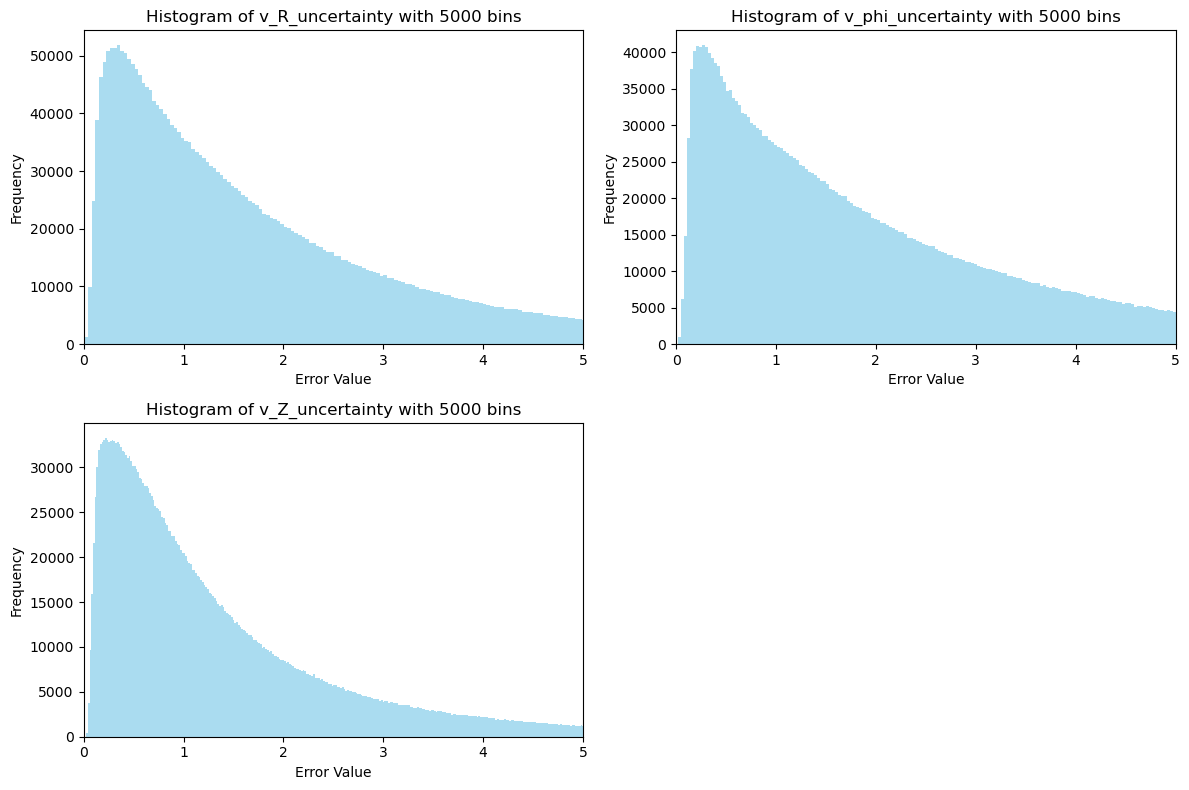

In [15]:
import matplotlib.pyplot as plt

# List of columns that are error-related (you can customize this based on your DataFrame's structure)
error_columns = ['v_R_uncertainty', 'v_phi_uncertainty', 'v_Z_uncertainty']  # Add any other error-related columns here

# Plot histograms for each error column with 50 bins, zoomed to 0-5
plt.figure(figsize=(12, 8))

for i, error_col in enumerate(error_columns):
    plt.subplot(2, 2, i + 1)  # Create a subplot for each error column
    plt.hist(df_v_final[error_col], bins=5000, color='skyblue', edgecolor=None, alpha=0.7)
    plt.title(f"Histogram of {error_col} with 5000 bins")
    plt.xlabel('Error Value')
    plt.ylabel('Frequency')
    plt.xlim(0, 5)  # Zoom in on the range from 0 to 5 for better visualization

# Adjust layout for better visualization
plt.tight_layout()
plt.show()
